### Steps
<pre>
1) Create ML Model
2) Save the Model
3) Create a ML model Web App using streamlit
4) Push the ML model and related file to github repo
5) Use Streamlit cloud to deployb the app from the github repo
</pre>

Requirements
<pre>
1) Jupyter
2) dataset
3) Dependencies - pandas, numpy, pickle, scikit-learn
4) Vs Code
5) Github account
6) Streamlit cloud account
</pre>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.shape

(1338, 7)

### Data Preproccessing
#### 1) Handling Null Values

In [6]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### 2) Handling Duplicates

In [7]:
df.duplicated().sum()

1

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

0

#### 3) Check data types

In [10]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

#### 4) Inconsistent Data

In [11]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


#### Seperate Num and Categorial features

In [12]:
num_cols = df.dtypes[df.dtypes!='object'].index
cat_cols = df.dtypes[df.dtypes=='object'].index
print(num_cols)
print(cat_cols)

Index(['age', 'bmi', 'children', 'charges'], dtype='object')
Index(['sex', 'smoker', 'region'], dtype='object')


#### Correlation

In [13]:
corr = df[num_cols].corr()
corr

,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


### EDA

#### Univariate Analysis

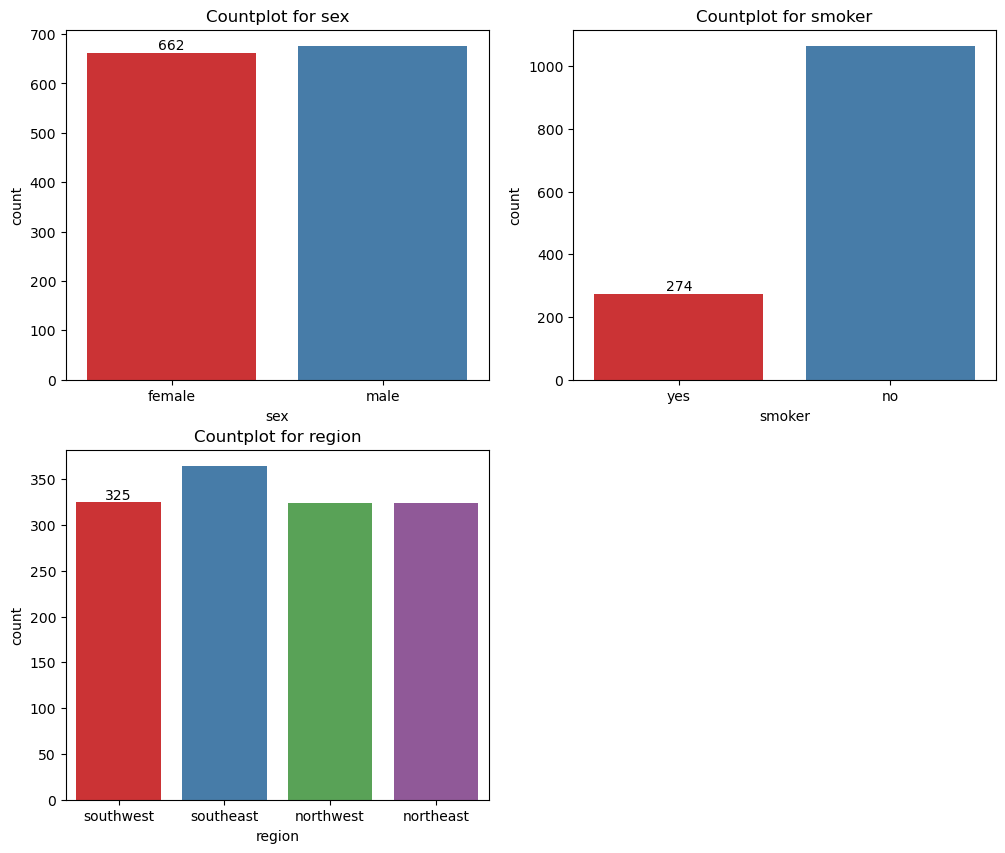

In [14]:
plt.figure(figsize=(12,10))
for i in range(len(cat_cols)):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(x=df[cat_cols[i]],palette='Set1')
    ax.bar_label(ax.containers[0])
    plt.title(f'Countplot for {cat_cols[i]}')

plt.show()

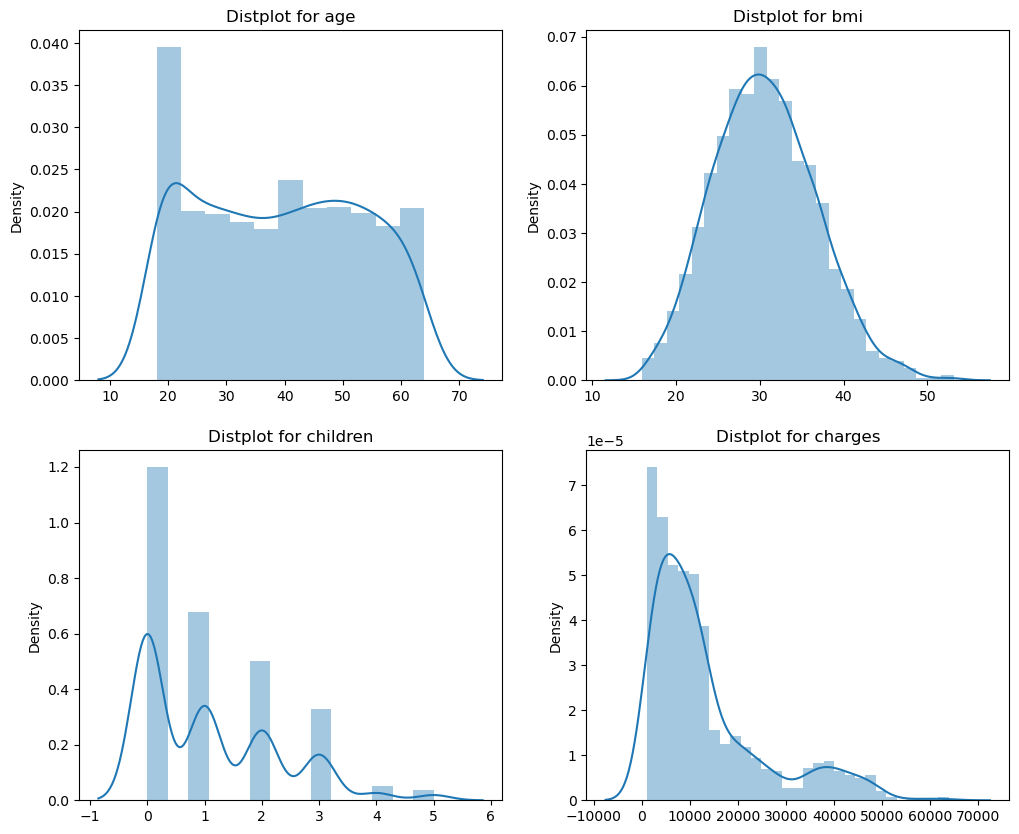

In [15]:
plt.figure(figsize=(12,10))
for i in range(len(num_cols)):
    plt.subplot(2,2,i+1)
    sns.distplot(x=df[num_cols[i]])
    plt.title(f'Distplot for {num_cols[i]}')

plt.show()

#### Outlier Treatment

<function matplotlib.pyplot.show(close=None, block=None)>

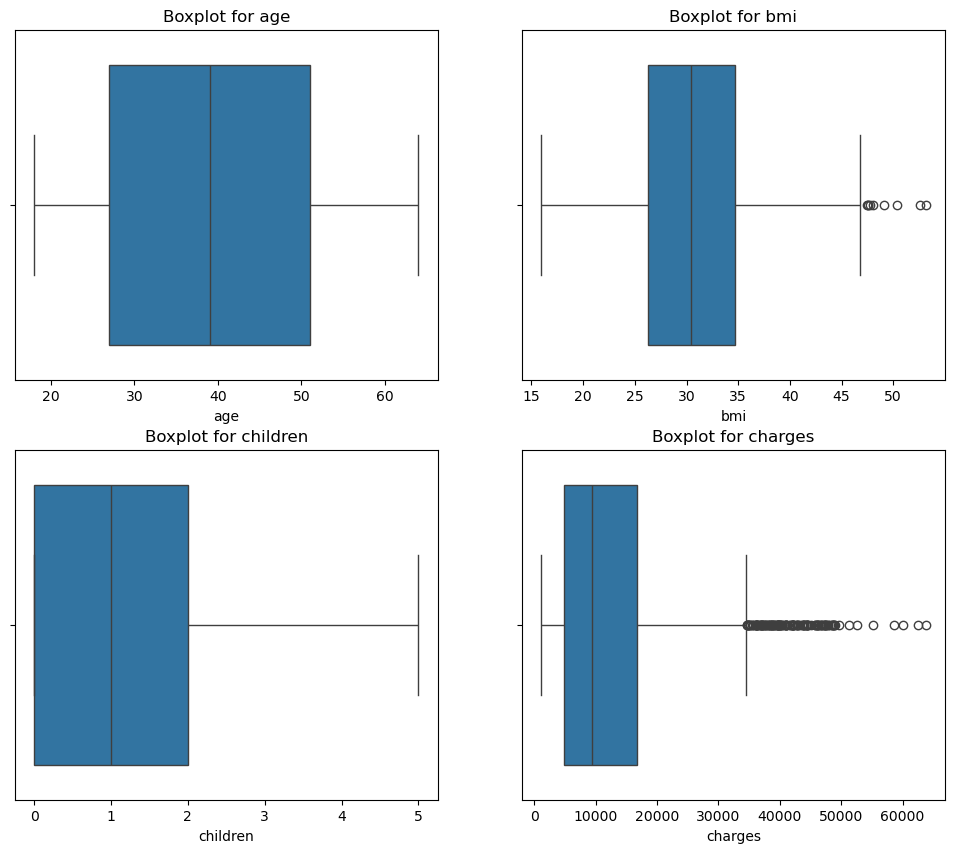

In [16]:
plt.figure(figsize=(12,10))
for i in range(len(num_cols)):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=df[num_cols[i]])
    plt.title(f'Boxplot for {num_cols[i]}')

plt.show

In [17]:
cols = ['bmi','charges']

a = df[cols].describe(percentiles=[0.95,0.96,0.97,0.98,0.99]).T
a = a.iloc[:,4:]
a

,50%,95%,96%,97%,98%,99%,max
bmi,30.4000,41.1080,41.800000,42.455200,43.920800,46.411200,53.13000
charges,9386.1613,41210.0498,42920.126232,44495.190584,46677.324238,48537.796878,63770.42801


In [18]:
print(df[df['bmi']>46.411200].shape)
print(df[df['charges']>41210.0498].shape)

(14, 7)
(67, 7)


In [19]:
df1 = df.copy()

#### Outlier Capping

In [20]:
df['bmi'] = np.where(df['bmi']>46.411200,46.411200,df['bmi'])
df['charges'] = np.where(df['charges']>41210.0498,41210.0498,df['charges'])

<function matplotlib.pyplot.show(close=None, block=None)>

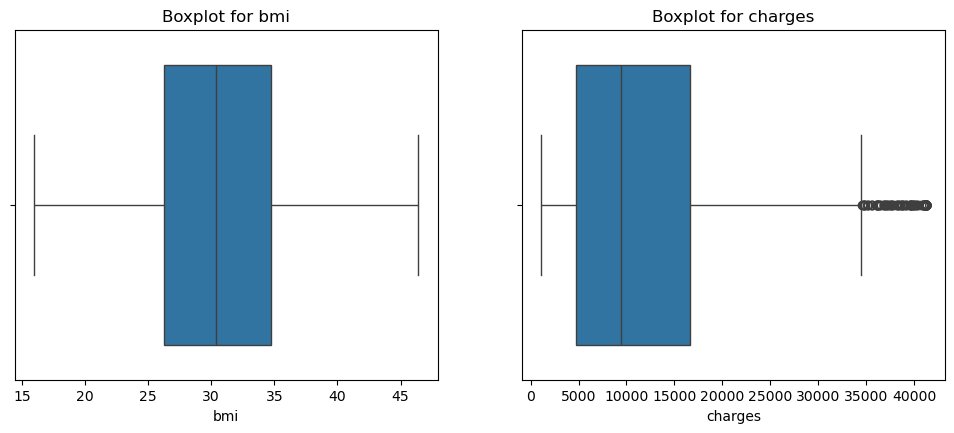

In [21]:
cols = ['bmi','charges']

plt.figure(figsize=(12,10))
for i in range(len(cols)):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=df[cols[i]])
    plt.title(f'Boxplot for {cols[i]}')

plt.show

#### Encode categorical Features

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
lb= LabelEncoder()
for i in cat_cols:
    df[i] = lb.fit_transform(df[i])

In [24]:
df.dtypes

age           int64
sex           int32
bmi         float64
children      int64
smoker        int32
region        int32
charges     float64
dtype: object

#### Select x and y

In [25]:
x = df.drop('charges',axis=1)
y = df['charges']
print(x.shape)
print(y.shape)

(1337, 6)
(1337,)


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=80)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(935, 6)
(402, 6)
(935,)
(402,)


#### Function to evaluate Model performance

In [28]:
from sklearn.metrics import *

In [29]:
def eval_model(model,x_train,x_test,y_train,y_test,mname):
    model.fit(x_train,y_train)
    ypred = model.predict(x_test)
    train_score = model.score(x_train,y_train)
    test_score = model.score(x_test,y_test)
    test_mse =  mean_squared_error(y_test,ypred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test,ypred)
    res = pd.DataFrame({'Train_Score':train_score,'Test_Score':test_score,
                       'Test_MAE':test_mae,'Test_MSE':test_mse,'Test_rmse':test_rmse},
                      index=[mname])
    return res,ypred

#### Import ML Models

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor

In [31]:
lr1 = LinearRegression()
lr1_res,ypred_lr1 = eval_model(lr1,x_train, x_test, y_train, y_test,'LinReg')
lr1_res

,Train_Score,Test_Score,Test_MAE,Test_MSE,Test_rmse
LinReg,0.755168,0.754061,3713.730183,3.008791e+07,5485.245197


#### DT Reg

In [32]:
dt1 = DecisionTreeRegressor(max_depth=8,min_samples_split=10)
dt1_res,ypred_dt1 = eval_model(dt1, x_train, x_test, y_train, y_test,'DTree_Reg')
dt1_res

,Train_Score,Test_Score,Test_MAE,Test_MSE,Test_rmse
DTree_Reg,0.916553,0.809411,2544.91753,2.331639e+07,4828.70501


#### Random Forest Regressor

In [33]:
rf1 = RandomForestRegressor(n_estimators=80,max_depth=9,min_samples_split=12)
rf1_res,ypred_rf1 = eval_model(rf1, x_train, x_test, y_train, y_test,'Rf_Reg')
rf1_res

,Train_Score,Test_Score,Test_MAE,Test_MSE,Test_rmse
Rf_Reg,0.912164,0.856615,2304.114335,1.754152e+07,4188.259521


#### Saving the Model

In [34]:
import pickle

In [35]:
pickle.dump(lr1,open('lr1_model_25May.pkl','wb'))  ## wb= write binary
pickle.dump(dt1,open('dt1_model_25May.pkl','wb'))  ## wb= write binary
pickle.dump(rf1,open('rf1_model_25May.pkl','wb'))  ## wb= write binary

#### Install Streamlit
Streamlit is a web framework-Used to create Web App

In [36]:
!pip install streamlit

In [37]:
import sklearn
print(sklearn.__version__)

1.5.0
